<a href="https://colab.research.google.com/github/alexf05/pclp3/blob/main/TEMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pclp3 tema
# FECHET Alex-Ciprian, 314CA
# JILAVEANU Mihnea, 314CA

Partea I - Fechet Alex
Am ales o problema de regresie liniara :predicția duratei de somn în funcție de obiceiuri zilnice.
Am optat pentru generarea sintetică a unui dataset care să aibă sens contextual.
Setul de date este compus din 9 coloane: varsta (numar intreg), gen ('M' sau 'F'), ore petrecute in fata unui ecran (nr real), numarul de cafele consumate (numar intreg), timpul de sport facut (masurat in minute - nr real), nivelul de stres (scazut/mediu/ridicat), ora de culcare (nr real; ora este trata ca un intreg - 0.1h = 6min) si coloana finala - durata de somn, pe care vom aplica si regresia liniara. Acesta este calculata cu o formula intuitiva, de la 8 ore, scadem proportional cu nr de ore de ecran, nr de cafele, zgomotului, si creste cu practicarea sportului.

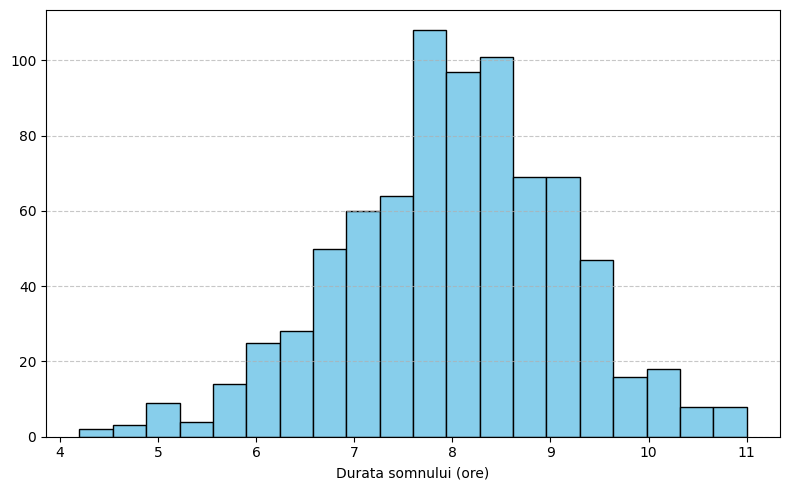

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
num_rows = 800

#stimulam variabile
# varsta si gen random
varsta = np.random.randint(18, 60, size=num_rows)
gen = np.random.choice(['M', 'F'], size=num_rows)
# distribuim gaussian in jurul la 5 si limitam la 0-12
ore_ecran = np.round(np.random.normal(5, 2, size=num_rows), 1)
ore_ecran = np.clip(ore_ecran, 0, 12)
minute_sport = np.random.normal(30, 10, size=num_rows)

# dsitribuim poisson
cafea = np.random.poisson(1.5, size=num_rows)
nivel_stres = np.random.choice(['scazut', 'mediu', 'ridicat'], size=num_rows, p=[0.3, 0.5, 0.2])

# ora de culcare intre 20 si 4
ora_culcare = np.random.normal(23, 1.5, size=num_rows)
ora_culcare = np.clip(ora_culcare, 20, 28)
ora_culcare = np.where(ora_culcare >= 24, ora_culcare - 24, ora_culcare)
ora_culcare = np.around(ora_culcare, 1)
#intre 60-80
zgomot = np.random.random(size=num_rows) * 20 + 60

# calculul somnului
# daca cineva se culca intre 22-24 durata somnului scade
# iar daca ora este dupa 00:30, durata creste
# 0.1->6 min
durata_somn = (
    8
    - 0.3 * ore_ecran
    - 0.4 * cafea
    + 0.08 * minute_sport * (minute_sport < 60)
    + 0.25 * (minute_sport > 60)
    - 0.15 * (((20 <= ora_culcare) & (ora_culcare <= 24)) * (ora_culcare - 22))
    + 0.15 * ora_culcare * ((4 >= ora_culcare) & (ora_culcare >= 0.5))
    - 0.5 * (zgomot > 70)
)
durata_somn = np.round(np.clip(durata_somn, 2, 11), 1)

df = pd.DataFrame({
    'varsta': varsta,
    'gen': gen,
    'ore_ecran': ore_ecran,
    'cafea': cafea,
    'minute_sport': minute_sport,
    'nivel_stres': nivel_stres,
    'ora_culcare': ora_culcare,
    'zgomot' : zgomot,
    'durata_somn': durata_somn
})

# verificam cum este distribuita variabila
plt.figure(figsize=(8, 5))
plt.hist(df["durata_somn"].dropna(), bins=20, edgecolor='black', color='skyblue')
plt.xlabel("Durata somnului (ore)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#stimulam lipsuri, 5% din totalul celulelor
total_cells = df.shape[0] * df.shape[1]
num_missing = int(total_cells * 0.05)

# in afara de coloana cu durata de somn, eliminam valori random
for i in range(num_missing):
    row = np.random.randint(0, df.shape[0])
    col = np.random.randint(0, 8)

    df.iat[row, col] = np.nan


# exportam data seturile (cel intreg, cel de test si de train)
df.to_csv("full_dataset.csv", index=False)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.to_csv("train_dataset.csv", index=False)
df_test.to_csv("test_dataset.csv", index=False)

# impartim pentru test si train cu durata de somn separat pentru regresie
X = df.iloc[:, 0:8]
y = df.iloc[:, 8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [11]:
print("Valori lipsă - X_train:\n", X_train.isnull().sum())
print("\nValori lipsă - X_test:\n", X_test.isnull().sum())

# pentru fiecare coloana calculam media, din full dataset
mean_values_train = X_train.mean(numeric_only=True)
mean_values_test = X_test.mean(numeric_only=True)
mean_values = (mean_values_test + mean_values_train) / 2

# inlocuim varibilele lipse cu media
X_train = X_train.fillna(mean_values)
X_test = X_test.fillna(mean_values)


Valori lipsă - X_train:
 varsta          38
gen             34
ore_ecran       41
cafea           30
minute_sport    37
nivel_stres     25
ora_culcare     38
zgomot          33
dtype: int64

Valori lipsă - X_test:
 varsta          10
gen              5
ore_ecran       11
cafea           10
minute_sport    12
nivel_stres      5
ora_culcare     11
zgomot          12
dtype: int64


In [12]:
# pentru descrierea varibilelor
print("X_train:")
print(X_train.describe())

print("\nX_test:")
print(X_test.describe())

# si pentru cele categorice (gen si nivel stres.)
print("\nX_train:")
print(X_train.describe(include='object'))

print("\nX_test:")
print(X_test.describe(include='object'))


X_train:
           varsta   ore_ecran       cafea  minute_sport  ora_culcare  \
count  640.000000  640.000000  640.000000    640.000000   640.000000   
mean    38.981853    5.179570    1.417613     30.161651    16.982944   
std     11.870475    1.944192    1.169654      9.371441     9.112438   
min     18.000000    0.000000    0.000000     -0.195122     0.000000   
25%     29.000000    3.875000    1.000000     24.475219    17.360105   
50%     39.000000    5.217675    1.000000     30.181877    21.800000   
75%     49.000000    6.400000    2.000000     36.360763    23.000000   
max     59.000000   10.200000    6.000000     61.931076    24.000000   

           zgomot  
count  640.000000  
mean    69.688445  
std      5.537881  
min     60.004820  
25%     64.934480  
50%     69.773606  
75%     73.898303  
max     79.978094  

X_test:
           varsta   ore_ecran       cafea  minute_sport  ora_culcare  \
count  160.000000  160.000000  160.000000    160.000000   160.000000   
mean    3

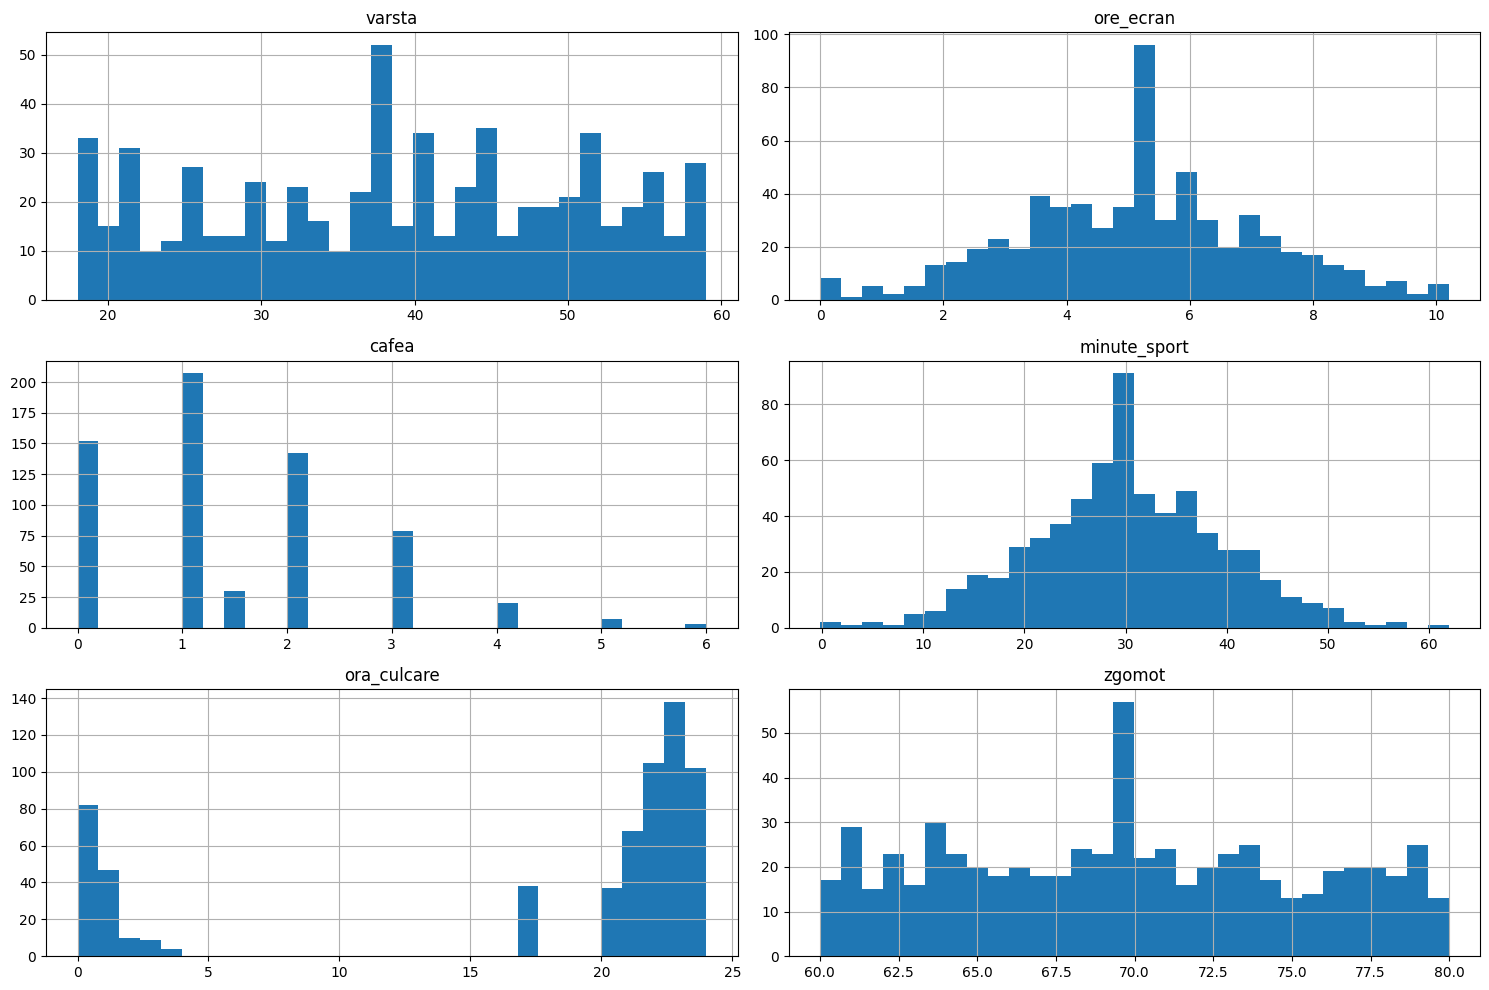

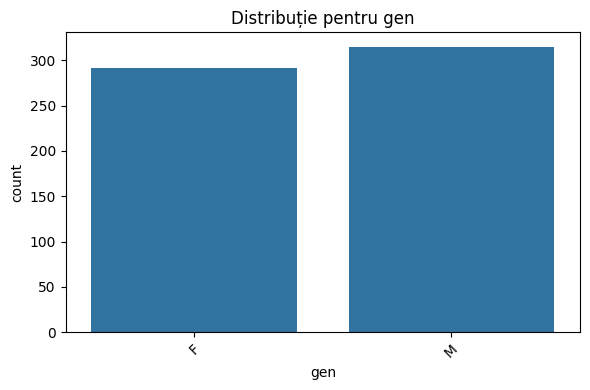

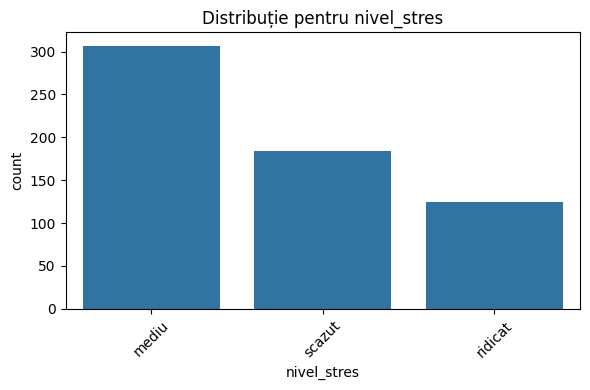

In [13]:
# Histograme pentru varibilel numerice
# am optat pentru "galeti" ca sa nu ma chinui pentru varibilele care sunt continue sau nu
X_train.select_dtypes(include=['int64', 'float64']).hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Countplot pentru categorice (gen si nivel stres)
for col in X_train.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=X_train, x=col)
    plt.title(f"Distribuție pentru {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

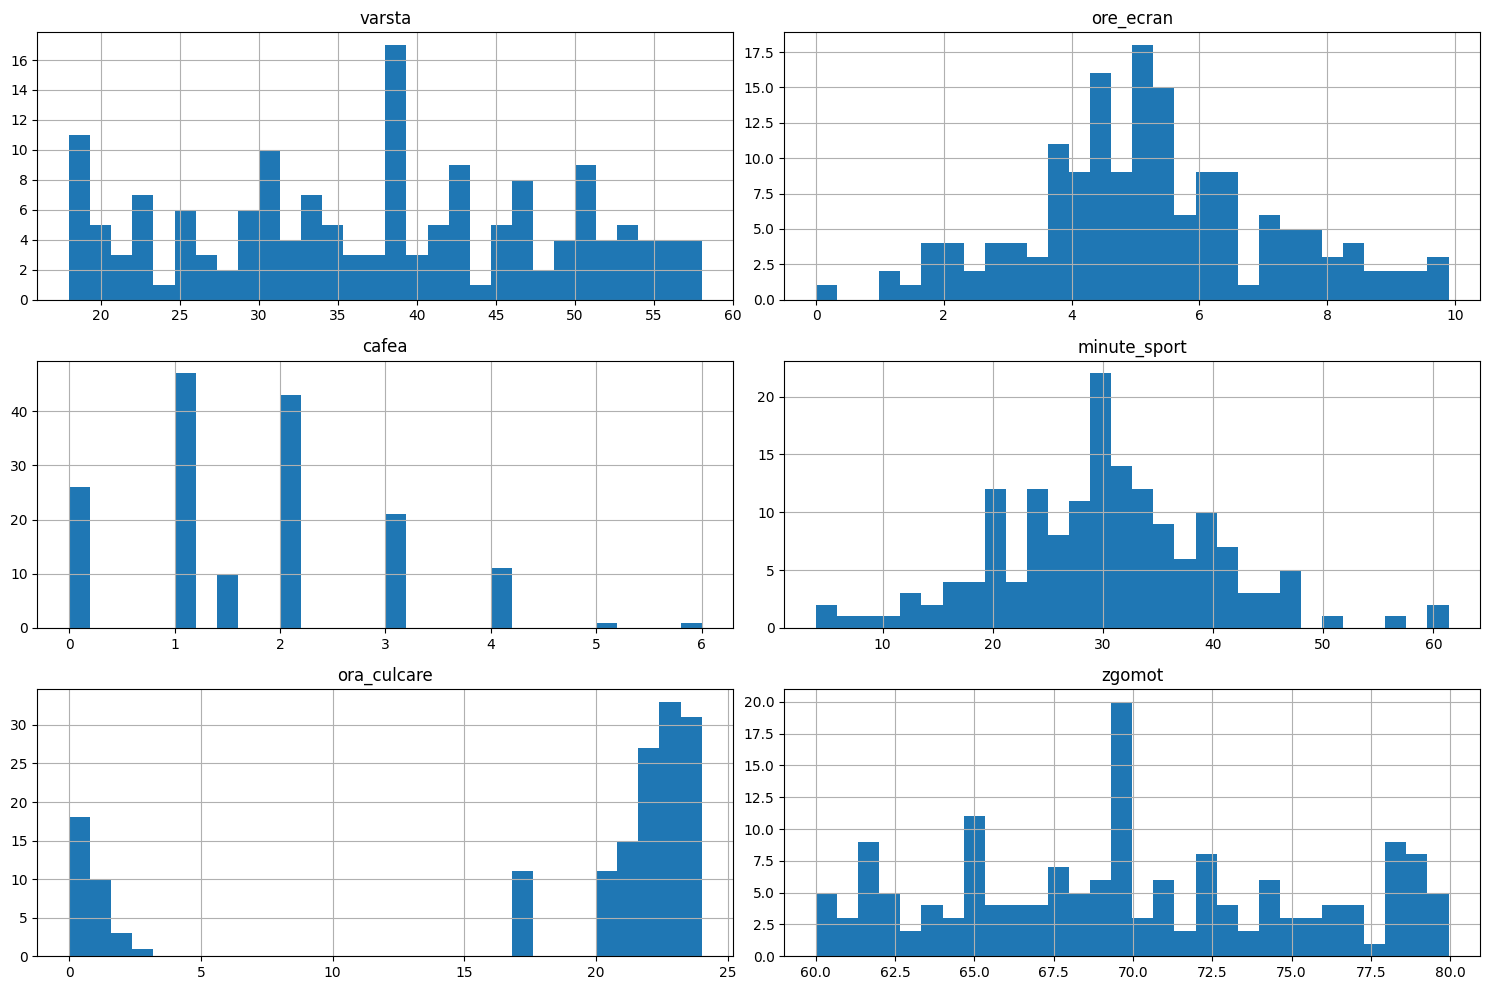

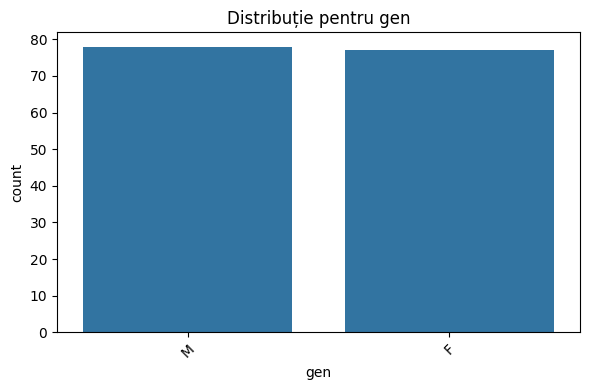

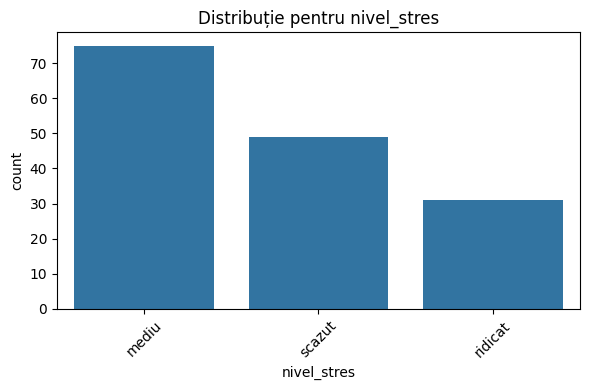

In [14]:
#similar si pentru test, dat fiind distribuirea variabilelor, graficele trebuie
# sa fie similare, cun mentiunea unor diferente, dat fiind nr mai mic de entitati
X_test.select_dtypes(include=['int64', 'float64']).hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

for col in X_test.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=X_test, x=col)
    plt.title(f"Distribuție pentru {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

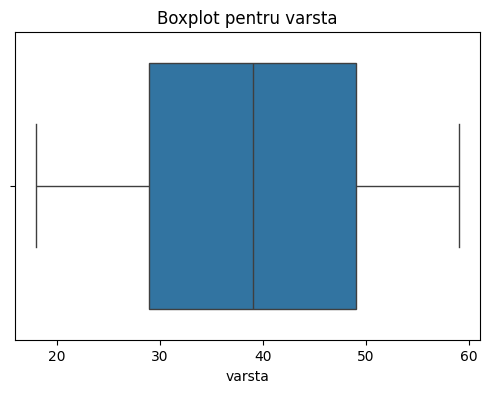

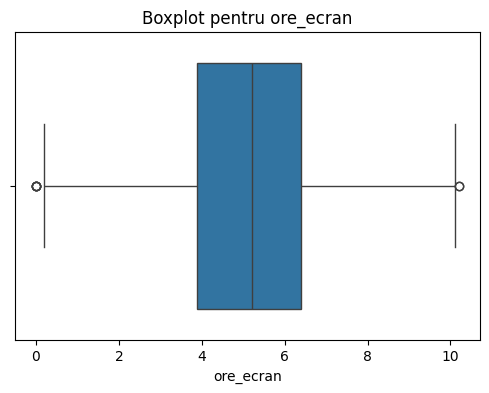

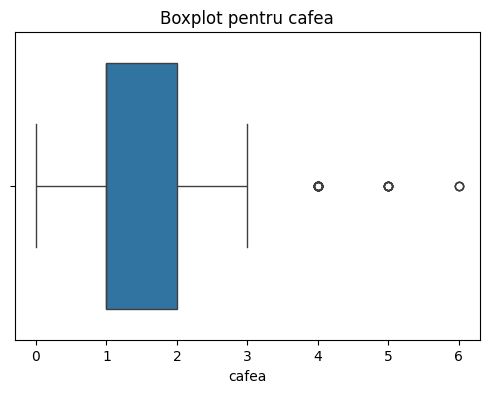

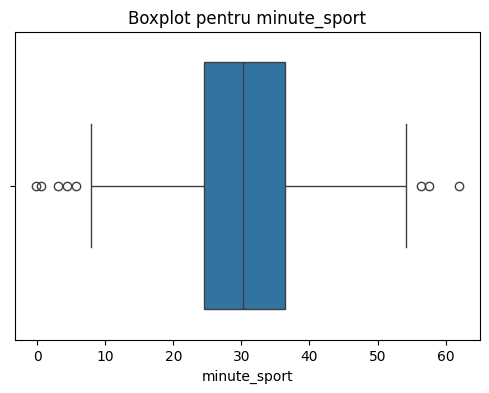

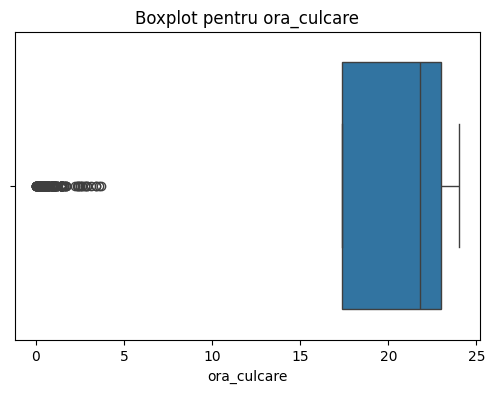

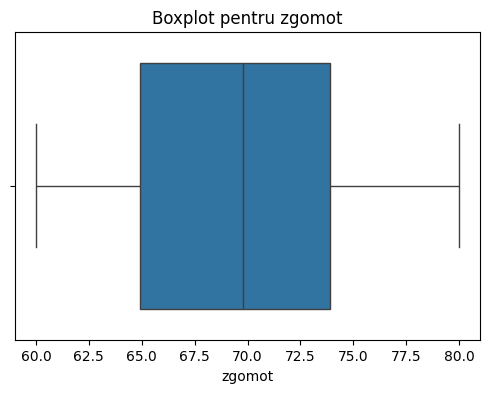

In [15]:
# Boxplot pentru fiecare coloană numerică
for col in X_train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=X_train[col])
    plt.title(f"Boxplot pentru {col}")
    plt.show()

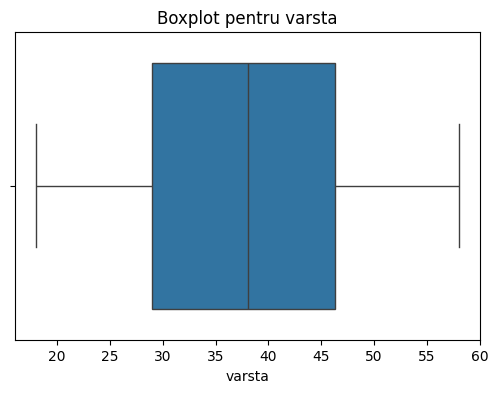

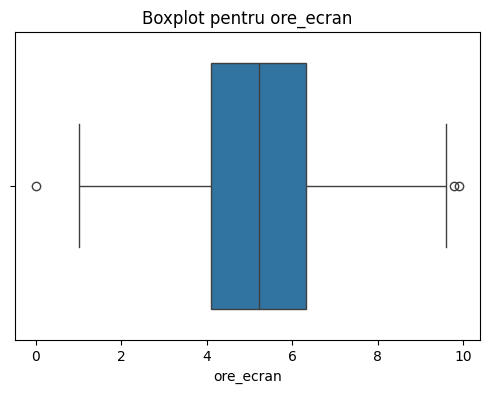

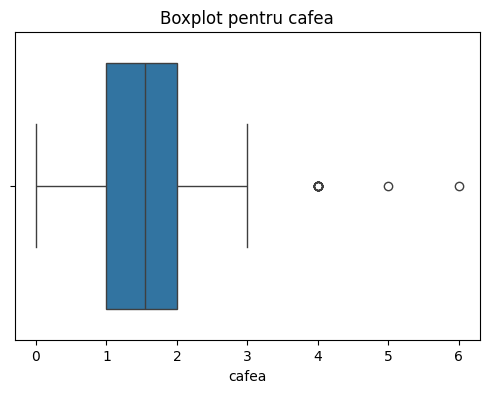

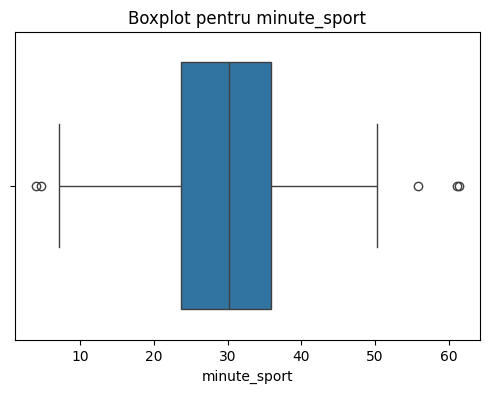

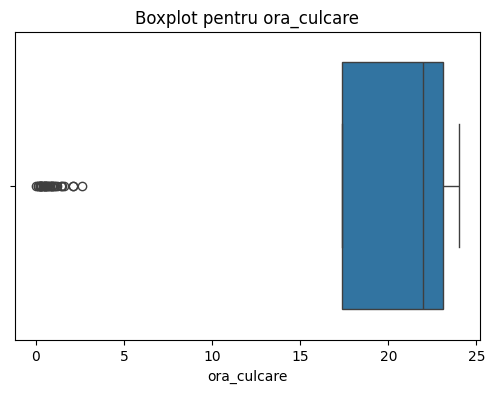

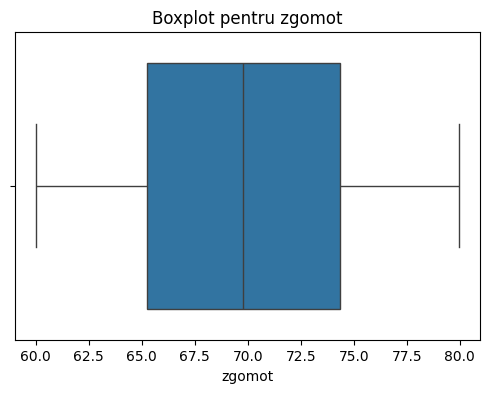

In [16]:
for col in X_test.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=X_test[col])
    plt.title(f"Boxplot pentru {col}")
    plt.show()

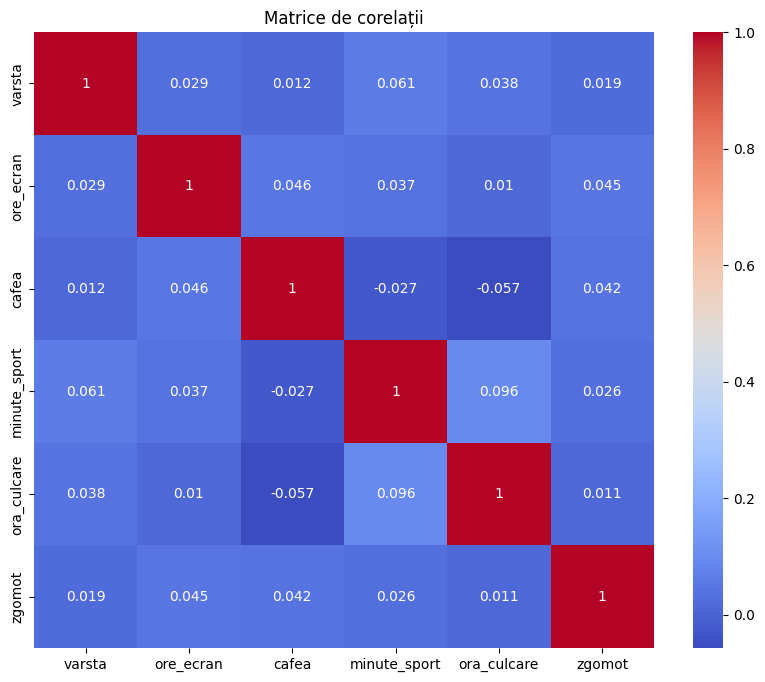

In [17]:
corr = X_train.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matrice de corelații")
plt.show()


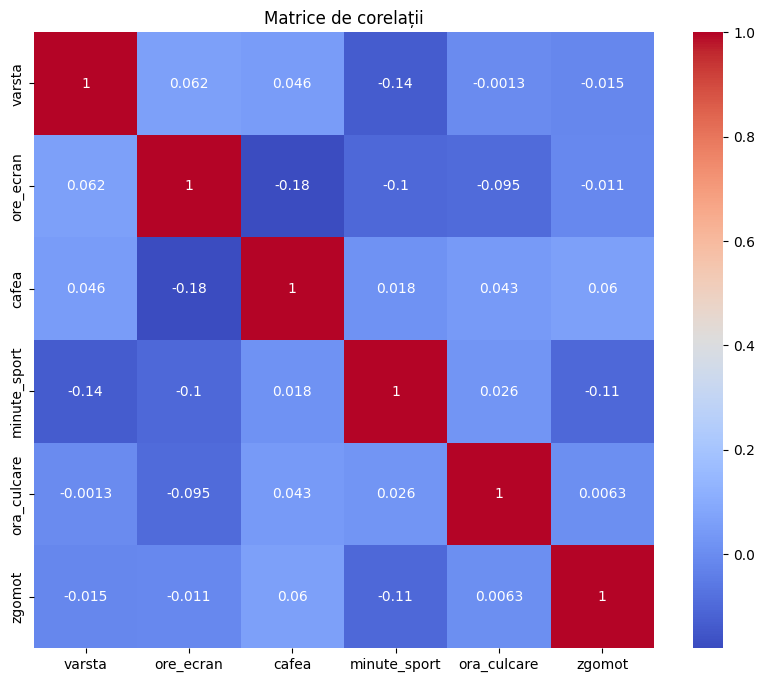

In [6]:
corr = X_test.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matrice de corelații")
plt.show()

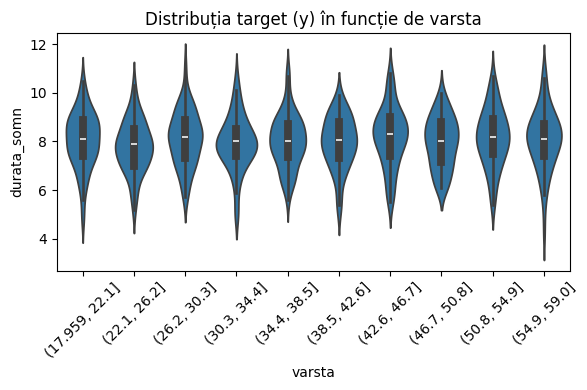

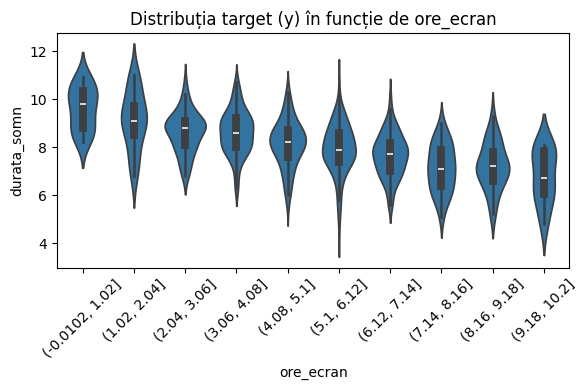

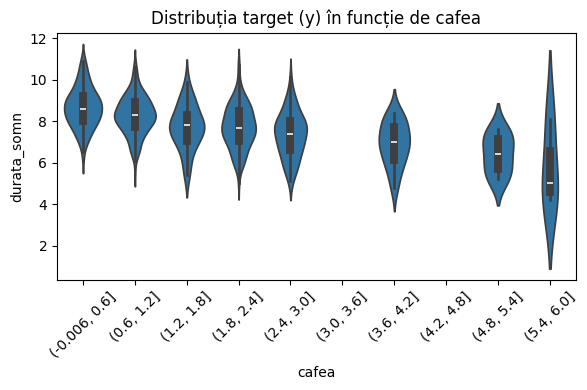

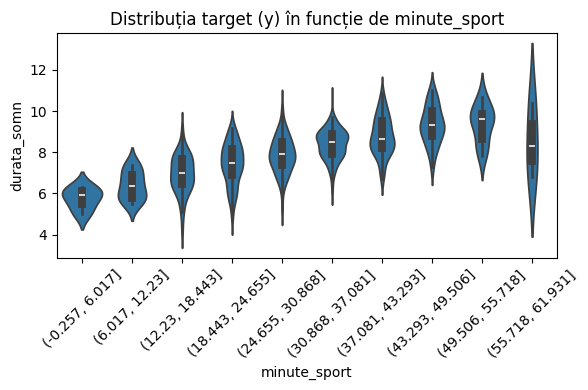

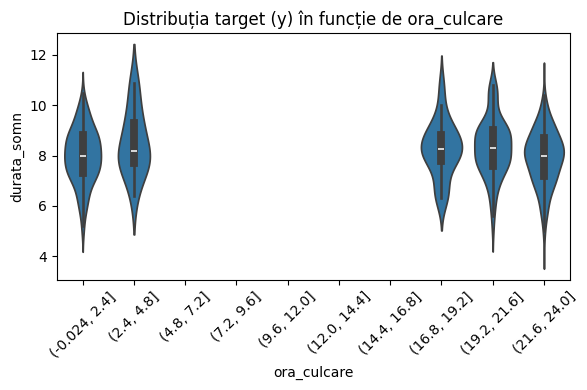

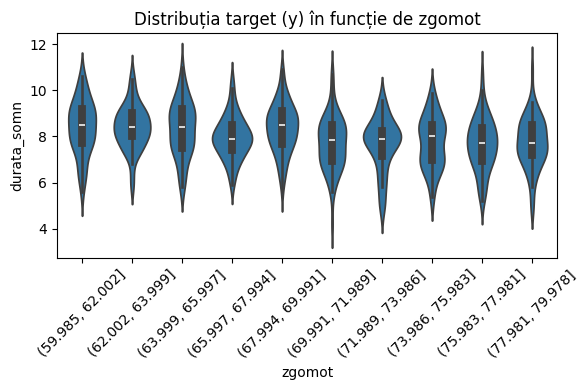

In [18]:
for col in X_train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(6, 4))
    # Grupăm valorile în 10 categorii (bins)
    binned = pd.cut(X_train[col], bins=10)
    sns.violinplot(x=binned, y=y_train)
    plt.xticks(rotation=45)
    plt.title(f"Distribuția target (y) în funcție de {col}")
    plt.tight_layout()
    plt.show()


In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train.select_dtypes(include=[np.number]), y_train)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicții pe test
y_pred = model.predict(X_test.select_dtypes(include=[np.number]))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 0.63
MAE: 0.29
R²: 0.72


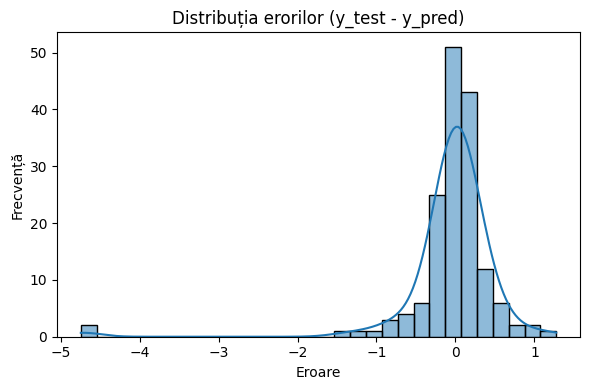

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

errors = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(errors, kde=True, bins=30)
plt.title("Distribuția erorilor (y_test - y_pred)")
plt.xlabel("Eroare")
plt.ylabel("Frecvență")
plt.tight_layout()
plt.show()


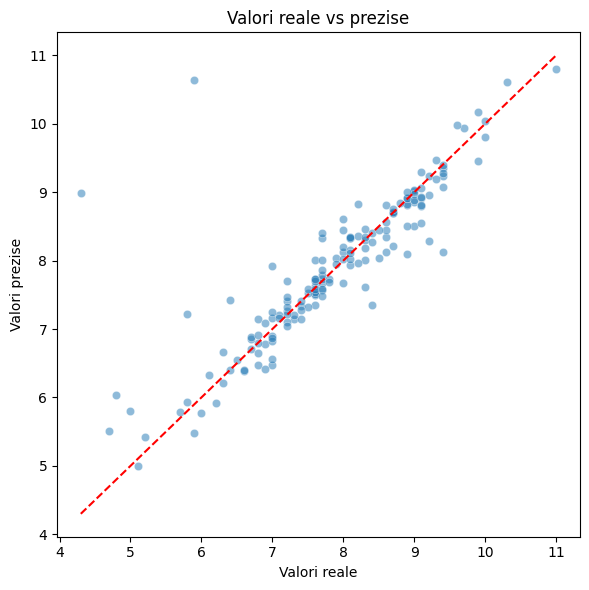

In [23]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valori reale")
plt.ylabel("Valori prezise")
plt.title("Valori reale vs prezise")
plt.tight_layout()
plt.show()
